# Prot T5 Finetuning
# per protein prediction

This notebook allows you to finetune PLMs to your own datasets

For better perfomance we apply [Parameter-Efficient Fine-Tuning (PEFT)](https://huggingface.co/blog/peft). For this we apply [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685).

The core training loop is implemented with the pytorch [huggingface trainer](https://huggingface.co/docs/transformers/main_classes/trainer).

In case it is needed for higher memory efficiency, we utilize the [deepspeed](https://github.com/microsoft/DeepSpeed) implementation of [huggingface](https://huggingface.co/docs/accelerate/usage_guides/deepspeed).

## Imports and env. variables

In [1]:
#import dependencies
import os.path
os.chdir("set working path here")


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import EsmModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, set_seed

import peft
from peft import get_peft_config, PeftModel, PeftConfig, inject_adapter_in_model, LoraConfig

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [2]:
# Set environment variables to run Deepspeed from a notebook
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

# Environment to run this notebook


These are the versions of the core packages we use to run this notebook:

In [3]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  1.13.1
Cuda version:  11.7
Numpy version:  1.22.3
Pandas version:  2.0.3
Transformers version:  4.26.1
Datasets version:  2.9.0


**For easy setup of this conda environment you can use the finetuning.yml File provided in this folder**

check here for [setting up env from a yml File](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file)

# Model checkpoints

This notebook was tested with all models mentioned below.
All required, model specific adaptations will be taken care of.

In [4]:
ESMs = ["facebook/esm2_t6_8M_UR50D",
         "facebook/esm2_t12_35M_UR50D",
         "facebook/esm2_t30_150M_UR50D",
         "facebook/esm2_t33_650M_UR50D",
         "facebook/esm2_t36_3B_UR50D"]

T5s = ["Rostlab/prot_t5_xl_uniref50",
       'Rostlab/ProstT5',
       "ElnaggarLab/ankh-base",
       "ElnaggarLab/ankh-large"]

### Select your model:

In [5]:
checkpoint = T5s[0]

# Input data

Provide your training and validation data in seperate pandas dataframes 

example shown below

In [6]:
# For this example we import the "three_vs_rest" GB1 dataset from https://github.com/J-SNACKKB/FLIP
# For details, see publication here: https://openreview.net/forum?id=p2dMLEwL8tF
import requests
import zipfile
from io import BytesIO

# Download the zip file from GitHub
url = 'https://github.com/J-SNACKKB/FLIP/raw/main/splits/gb1/splits.zip'
response = requests.get(url)
zip_file = zipfile.ZipFile(BytesIO(response.content))

# Load the `three_vs_rest.csv` file into a pandas dataframe
with zip_file.open('splits/three_vs_rest.csv') as file:
    df = pd.read_csv(file)

In [7]:
# Drop test data
df=df[df.set=="train"]

# Get train and validation data
my_train=df[df.validation!=True].reset_index(drop=True)
my_valid=df[df.validation==True].reset_index(drop=True)

# Set column names to "sequence" and "label"
my_train.columns=["sequence","label"]+list(my_train.columns[2:])
my_valid.columns=["sequence","label"]+list(my_valid.columns[2:])

# Drop unneeded columns
my_train=my_train[["sequence","label"]]
my_valid=my_valid[["sequence","label"]]

**Modify the data loading part above as needed for your data**

To run the training you need two dataframes (training and validation) each with the columns "sequence" and "label"

Labels are:
+ a float value for **regression**
+ the class as an integer for **classification** (from 0 to number of classes - 1)

In [8]:
my_train.head(5)

,sequence,label
0,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.000000
1,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIDGEWTYD...,1.445905
2,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGLDGEWTYD...,1.690164
3,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGMDGEWTYD...,1.170550
4,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVAGEWTYD...,2.401243


In [9]:
my_valid.head(5)

,sequence,label
0,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVEGEWTYD...,0.860931
1,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVQGEWTYD...,1.113894
2,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVTGEWTYD...,1.165465
3,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVYGEWTYD...,3.891461
4,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGCIGEWTYD...,1.172411


# Models and Low Rank Adaptation

## T5 Models

### Classification model definition 

adding a classifcation or regression head (num_labels = 1) on top of the encoder model

modified from https://gist.github.com/sam-writer/723baf81c501d9d24c6955f201d86bbb

In [10]:
class ClassConfig:
    def __init__(self, dropout=0.2, num_labels=1):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)

    def forward(self, hidden_states):

        hidden_states =  torch.mean(hidden_states,dim=1)  # avg embedding

        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = torch.tanh(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.out_proj(hidden_states)
        return hidden_states

class T5EncoderForSimpleSequenceClassification(T5PreTrainedModel):

    def __init__(self, config: T5Config, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(class_config.dropout_rate) 
        self.classifier = T5EncoderClassificationHead(config, class_config)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.classifier = self.classifier.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

### Load T5 model
this creates a T5 model with prediction head and LoRA modification

In [11]:
def load_T5_model(checkpoint, num_labels, half_precision, full=False, deepspeed=True):
    
    # Load model and tokenizer

    if "ankh" in checkpoint :
        model = T5EncoderModel.from_pretrained(checkpoint)
        tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    elif "prot_t5" in checkpoint:
        # possible to load the half precision model (thanks to @pawel-rezo for pointing that out)
        if half_precision and deepspeed : 
            tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)
            model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc", torch_dtype=torch.float16)#.to(torch.device('cuda')
        else:
            model = T5EncoderModel.from_pretrained(checkpoint)
            tokenizer = T5Tokenizer.from_pretrained(checkpoint)
                
    elif "ProstT5" in checkpoint:
        if half_precision and deepspeed: 
            tokenizer = T5Tokenizer.from_pretrained(checkpoint, do_lower_case=False)
            model = T5EncoderModel.from_pretrained(checkpoint, torch_dtype=torch.float16)#.to(torch.device('cuda')
        else:
            model = T5EncoderModel.from_pretrained(checkpoint)
            tokenizer = T5Tokenizer.from_pretrained(checkpoint)                

    
    # Create new Classifier model with PT5 dimensions
    class_config=ClassConfig(num_labels=num_labels)
    class_model=T5EncoderForSimpleSequenceClassification(model.config,class_config)
    
    # Set encoder and embedding weights to checkpoint weights
    class_model.shared=model.shared
    class_model.encoder=model.encoder    
    
    # Delete the checkpoint model
    model = class_model
    del class_model
    
    if full == True:
        return model, tokenizer 
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("T5_Classfier\nTrainable Parameter: "+ str(params))    
 
    # lora modification
    peft_config = LoraConfig(
        r=4, lora_alpha=1, bias="all", target_modules=["q","k","v","o"]
    )
    
    model = inject_adapter_in_model(peft_config, model)
    
    # Unfreeze the prediction head
    for (param_name, param) in model.classifier.named_parameters():
                param.requires_grad = True    
    
    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("T5_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
    return model, tokenizer

## ESM2 Models

In [12]:
#load ESM2 models
def load_esm_model(checkpoint, num_labels, half_precision, full = False, deepspeed=True):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    
    if half_precision and deepspeed:
        model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, torch_dtype=torch.float16)
    else:
        model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)
    
    if full == True:
        return model, tokenizer        
    
    peft_config = LoraConfig(
        r=4, lora_alpha=1, bias="all", target_modules=["query","key","value","dense"]
    )
    
    model = inject_adapter_in_model(peft_config, model)
    
    # Unfreeze the prediction head
    for (param_name, param) in model.classifier.named_parameters():
                param.requires_grad = True
       
    return model, tokenizer

# Training Definition 

## Deepspeed config

In [13]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

## Training functions

In [14]:
# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

# Dataset creation
def create_dataset(tokenizer,seqs,labels):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    dataset = dataset.add_column("labels", labels)

    return dataset
    
# Main training fuction
def train_per_protein(
        checkpoint,       #model checkpoint
    
        train_df,         #training data
        valid_df,         #validation data      
        num_labels = 1,   #1 for regression, >1 for classification
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch = 4,        #for training
        accum = 2,        #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs = 10,      #training epochs
        lr = 3e-4,        #recommended learning rate
        seed = 42,        #random seed
        deepspeed = False,#if gpu is large enough disable deepspeed for training speedup
        mixed = True,     #enable mixed precision training
        full = False,     #enable training of the full model (instead of LoRA)
        gpu = 1 ):        #gpu selection (1 for first gpu)

    print("Model used:", checkpoint, "\n")
    
    # Correct incompatible training settings
    if "ankh" in checkpoint and mixed:
        print("Ankh models do not support mixed precision training!")
        print("switched to FULL PRECISION TRAINING instead")
        mixed = False

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    if "esm" in checkpoint:
        model, tokenizer = load_esm_model(checkpoint, num_labels, mixed, full, deepspeed)
    else:
        model, tokenizer = load_T5_model(checkpoint, num_labels, mixed, full, deepspeed)

    # Preprocess inputs
    # Replace uncommon AAs with "X"
    train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z","J"]),"X",regex=True)
    valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z","J"]),"X",regex=True)
    
    # Add spaces between each amino acid for ProtT5 and ProstT5 to correctly use them
    if "Rostlab" in checkpoint:
        train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
        valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
        
    # Add <AA2fold> for ProstT5 to inform the model of the input type (amino acid sequence here)
    if "ProstT5" in checkpoint:    
        train_df['sequence']=train_df.apply(lambda row : "<AA2fold> " + row["sequence"], axis = 1)  
        valid_df['sequence']=valid_df.apply(lambda row : "<AA2fold> " + row["sequence"], axis = 1)  
 

    # Create Datasets
    train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
    valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

    # Huggingface Trainer arguments
    args = TrainingArguments(
        "./scripts/Finetuning/PT5/",
        evaluation_strategy = "epoch",
        logging_strategy = "epoch",
        save_strategy = "no",
        learning_rate=lr,
        per_device_train_batch_size=batch,
        per_device_eval_batch_size=val_batch,
        gradient_accumulation_steps=accum,
        num_train_epochs=epochs,
        seed = seed,
        deepspeed= ds_config if deepspeed else None,
        fp16 = mixed,
    ) 

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        if num_labels>1:  # for classification
            metric = load("accuracy")
            predictions, labels = eval_pred
            predictions = np.argmax(predictions, axis=1)
        else:  # for regression
            metric = load("spearmanr")
            predictions, labels = eval_pred

        return metric.compute(predictions=predictions, references=labels)
    
    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_set,
        eval_dataset=valid_set,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )    
    
    # Train model
    trainer.train()

    return tokenizer, model, trainer.state.log_history


# Run Training

## Training

In [15]:
tokenizer, model, history = train_per_protein(checkpoint, my_train, my_valid, num_labels = 1, batch = 1, accum = 8, epochs = 20, seed = 42, mixed = True)

Model used: Rostlab/prot_t5_xl_uniref50 

T5_Classfier
Trainable Parameter: 1209192449
T5_LoRA_Classfier
Trainable Parameter: 3017729

[2024-04-23 12:11:30,530] [INFO] [comm.py:657:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


Using cuda_amp half precision backend


[2024-04-23 12:11:30,810] [INFO] [logging.py:75:log_dist] [Rank 0] DeepSpeed info: version=0.8.1, git-hash=unknown, git-branch=unknown
[2024-04-23 12:11:32,243] [INFO] [logging.py:75:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
[2024-04-23 12:11:33,461] [WARNING] [cpu_adam.py:83:__init__] FP16 params for CPUAdam may not work on AMD CPUs


Using /homes/schmirx6/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /homes/schmirx6/.cache/torch_extensions/py39_cu117/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module cpu_adam...


ninja: no work to do.
Time to load cpu_adam op: 3.030212640762329 seconds
[2024-04-23 12:11:38,183] [INFO] [logging.py:75:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adamw as basic optimizer
[2024-04-23 12:11:38,196] [INFO] [logging.py:75:log_dist] [Rank 0] DeepSpeed Basic Optimizer = DeepSpeedCPUAdam
[2024-04-23 12:11:38,197] [INFO] [utils.py:53:is_zero_supported_optimizer] Checking ZeRO support for optimizer=DeepSpeedCPUAdam type=<class 'deepspeed.ops.adam.cpu_adam.DeepSpeedCPUAdam'>
[2024-04-23 12:11:38,197] [INFO] [logging.py:75:log_dist] [Rank 0] Creating torch.float16 ZeRO stage 2 optimizer
[2024-04-23 12:11:38,198] [INFO] [stage_1_and_2.py:144:__init__] Reduce bucket size 200000000
[2024-04-23 12:11:38,198] [INFO] [stage_1_and_2.py:145:__init__] Allgather bucket size 200000000
[2024-04-23 12:11:38,199] [INFO] [stage_1_and_2.py:146:__init__] CPU Offload: True
[2024-04-23 12:11:38,199] [INFO] [stage_1_and_2.py:147:__init__] Round robin gradient partitioning: False


Using /homes/schmirx6/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...
Emitting ninja build file /homes/schmirx6/.cache/torch_extensions/py39_cu117/utils/build.ninja...
Building extension module utils...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module utils...


ninja: no work to do.
Time to load utils op: 0.4521915912628174 seconds
Rank: 0 partition count [1] and sizes[(3017730, False)] 
[2024-04-23 12:11:38,941] [INFO] [utils.py:825:see_memory_usage] Before initializing optimizer states
[2024-04-23 12:11:38,942] [INFO] [utils.py:826:see_memory_usage] MA 2.26 GB         Max_MA 2.26 GB         CA 2.46 GB         Max_CA 2 GB 
[2024-04-23 12:11:38,943] [INFO] [utils.py:834:see_memory_usage] CPU Virtual Memory:  used = 44.21 GB, percent = 23.7%
[2024-04-23 12:11:39,109] [INFO] [utils.py:825:see_memory_usage] After initializing optimizer states
[2024-04-23 12:11:39,111] [INFO] [utils.py:826:see_memory_usage] MA 2.26 GB         Max_MA 2.26 GB         CA 2.46 GB         Max_CA 2 GB 
[2024-04-23 12:11:39,111] [INFO] [utils.py:834:see_memory_usage] CPU Virtual Memory:  used = 44.23 GB, percent = 23.7%
[2024-04-23 12:11:39,112] [INFO] [stage_1_and_2.py:527:__init__] optimizer state initialized
[2024-04-23 12:11:39,272] [INFO] [utils.py:825:see_memory_u

[2024-04-23 12:11:39,298] [INFO] [config.py:1013:print]   load_universal_checkpoint .... False
[2024-04-23 12:11:39,298] [INFO] [config.py:1013:print]   loss_scale ................... 0
[2024-04-23 12:11:39,299] [INFO] [config.py:1013:print]   memory_breakdown ............. False
[2024-04-23 12:11:39,299] [INFO] [config.py:1013:print]   monitor_config ............... tensorboard=TensorBoardConfig(enabled=False, output_path='', job_name='DeepSpeedJobName') wandb=WandbConfig(enabled=False, group=None, team=None, project='deepspeed') csv_monitor=CSVConfig(enabled=False, output_path='', job_name='DeepSpeedJobName') enabled=False
[2024-04-23 12:11:39,300] [INFO] [config.py:1013:print]   nebula_config ................ {
    "enabled": false, 
    "persistent_storage_path": null, 
    "persistent_time_interval": 100, 
    "num_of_version_in_retention": 2, 
    "enable_nebula_load": true, 
    "load_path": null
}
[2024-04-23 12:11:39,305] [INFO] [config.py:1013:print]   optimizer_legacy_fusion

Using /homes/schmirx6/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...
No modifications detected for re-loaded extension module utils, skipping build step...
Loading extension module utils...
***** Running training *****
  Num examples = 2691
  Num Epochs = 20
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 8
  Total optimization steps = 6720
  Number of trainable parameters = 3017729


Time to load utils op: 0.001104116439819336 seconds
Adam Optimizer #0 is created with AVX2 arithmetic capability.
Config: alpha=0.000300, betas=(0.900000, 0.999000), weight_decay=0.000000, adam_w=1
[2024-04-23 12:11:40,387] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 65536, reducing to 65536


Epoch,Training Loss,Validation Loss,Spearmanr
0,1.246000,1.113281,0.447689
1,0.879200,0.690430,0.700878
2,0.758800,0.969238,0.714026
3,0.683100,0.773438,0.766609
4,0.637800,0.622559,0.791623
5,0.564100,0.536621,0.818390
6,0.507400,0.559082,0.818240
7,0.459200,0.411133,0.838511
8,0.425200,0.488770,0.829020
9,0.396200,0.327393,0.849673


[2024-04-23 12:11:41,350] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 65536, reducing to 32768.0
[2024-04-23 12:11:44,293] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 32768.0, reducing to 16384.0


***** Running Evaluation *****
  Num examples = 299
  Batch size = 16
***** Running Evaluation *****
  Num examples = 299
  Batch size = 16
***** Running Evaluation *****
  Num examples = 299
  Batch size = 16


[2024-04-23 12:32:28,659] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 32768.0, reducing to 32768.0


***** Running Evaluation *****
  Num examples = 299
  Batch size = 16


[2024-04-23 12:39:14,530] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 32768.0, reducing to 16384.0


***** Running Evaluation *****
  Num examples = 299
  Batch size = 16


[2024-04-23 12:46:47,776] [INFO] [logging.py:75:log_dist] [Rank 0] step=2000, skipped=5, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-04-23 12:46:47,777] [INFO] [timer.py:198:stop] epoch=0/micro_step=16000/global_step=2000, RunningAvgSamplesPerSec=8.064623711184668, CurrSamplesPerSec=9.179060500210502, MemAllocated=2.26GB, MaxMemAllocated=4.07GB


***** Running Evaluation *****
  Num examples = 299
  Batch size = 16
***** Running Evaluation *****
  Num examples = 299
  Batch size = 16
***** Running Evaluation *****
  Num examples = 299
  Batch size = 16
***** Running Evaluation *****
  Num examples = 299
  Batch size = 16
***** Running Evaluation *****
  Num examples = 299
  Batch size = 16


[2024-04-23 13:12:11,438] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 65536.0, reducing to 65536.0
[2024-04-23 13:12:12,341] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 65536.0, reducing to 32768.0


***** Running Evaluation *****
  Num examples = 299
  Batch size = 16


[2024-04-23 13:19:07,858] [INFO] [logging.py:75:log_dist] [Rank 0] step=4000, skipped=7, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-04-23 13:19:07,859] [INFO] [timer.py:198:stop] epoch=0/micro_step=32000/global_step=4000, RunningAvgSamplesPerSec=8.416593805437094, CurrSamplesPerSec=8.98256915731608, MemAllocated=2.26GB, MaxMemAllocated=4.07GB


***** Running Evaluation *****
  Num examples = 299
  Batch size = 16
***** Running Evaluation *****
  Num examples = 299
  Batch size = 16


[2024-04-23 13:28:42,717] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 65536.0, reducing to 65536.0
[2024-04-23 13:28:53,107] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 65536.0, reducing to 32768.0


***** Running Evaluation *****
  Num examples = 299
  Batch size = 16
***** Running Evaluation *****
  Num examples = 299
  Batch size = 16
***** Running Evaluation *****
  Num examples = 299
  Batch size = 16
***** Running Evaluation *****
  Num examples = 299
  Batch size = 16


[2024-04-23 13:47:38,338] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 65536.0, reducing to 65536.0
[2024-04-23 13:50:13,930] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 65536.0, reducing to 32768.0
[2024-04-23 13:52:01,813] [INFO] [logging.py:75:log_dist] [Rank 0] step=6000, skipped=11, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-04-23 13:52:01,815] [INFO] [timer.py:198:stop] epoch=0/micro_step=48000/global_step=6000, RunningAvgSamplesPerSec=8.491152162128799, CurrSamplesPerSec=8.998342431945447, MemAllocated=2.26GB, MaxMemAllocated=4.07GB


***** Running Evaluation *****
  Num examples = 299
  Batch size = 16
***** Running Evaluation *****
  Num examples = 299
  Batch size = 16
***** Running Evaluation *****
  Num examples = 299
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




## Plot results

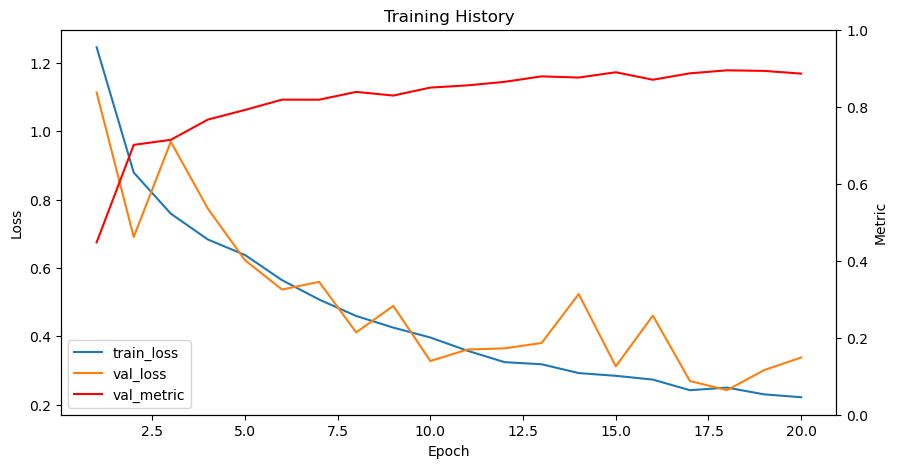

In [16]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss, label='val_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
line3 = ax2.plot(epochs, metric, color='red', label='val_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History")
plt.show()

# Save and Load the finetuned model

In [17]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(checkpoint, filepath, num_labels=1, mixed = True, full = False, deepspeed = True):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load model
    if "esm" in checkpoint:
        model, tokenizer = load_esm_model(checkpoint, num_labels, mixed, full, deepspeed)
    else:
        model, tokenizer = load_T5_model(checkpoint, num_labels, mixed, full, deepspeed)
        
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

This saves only the finetuned weights to a .pth file

The file has a size of only a few MB, while the entire model would be around 4.8 GB

In [18]:
save_model(model, "./ProtT5_GB1_finetuned.pth")

To load the weights again, we initialize a new PT5 model from the pretrained checkpoint and load the LoRA weights afterwards

You need to specifiy the correct num_labels here

In [19]:
tokenizer, model_reload = load_model(checkpoint, "./ProtT5_GB1_finetuned.pth", num_labels=1)

loading file spiece.model from cache at /data2/cache/huggingface/hub/models--Rostlab--prot_t5_xl_half_uniref50-enc/snapshots/94a6abc029ae13029317b140b7424e012bf8dfbf/spiece.model
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /data2/cache/huggingface/hub/models--Rostlab--prot_t5_xl_half_uniref50-enc/snapshots/94a6abc029ae13029317b140b7424e012bf8dfbf/special_tokens_map.json
loading file tokenizer_config.json from cache at /data2/cache/huggingface/hub/models--Rostlab--prot_t5_xl_half_uniref50-enc/snapshots/94a6abc029ae13029317b140b7424e012bf8dfbf/tokenizer_config.json
loading configuration file config.json from cache at /data2/cache/huggingface/hub/models--Rostlab--prot_t5_xl_half_uniref50-enc/snapshots/94a6abc029ae13029317b140b7424e012bf8dfbf/config.json
Model config T5Config {
  "_name_or_path": "Rostlab/prot_t5_xl_half_uniref50-enc",
  "architectures": [
    "T5EncoderModel"
  ],
  "d_ff": 16384,
  "d_kv": 128,
  "d_model": 1024,
 

T5_Classfier
Trainable Parameter: 1209192449
T5_LoRA_Classfier
Trainable Parameter: 3017729



To check if the original and the reloaded models are identical we can compare weights

In [20]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


# Make predictions on a test set

In [21]:
# For this we import the "three_vs_rest" GB1 dataset again 
# from https://github.com/J-SNACKKB/FLIP

import requests
import zipfile
from io import BytesIO

# Download the zip file from GitHub
url = 'https://github.com/J-SNACKKB/FLIP/raw/main/splits/gb1/splits.zip'
response = requests.get(url)
zip_file = zipfile.ZipFile(BytesIO(response.content))

# Load the `three_vs_rest.csv` file into a pandas dataframe
with zip_file.open('splits/three_vs_rest.csv') as file:
    df = pd.read_csv(file)

This time we take the test data

In [22]:
# Select only test data
my_test=df[df.set=="test"]

# Set column names to "sequence" and "label"
my_test.columns=["sequence","label"]+list(my_test.columns[2:])

# Drop unneeded columns
my_test=my_test[["sequence","label"]]
print(my_test.head(5))

# Preprocess sequences
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)


                                               sequence     label
2990  MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAAAEWTYD...  1.611610
2991  MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAACEWTYD...  3.741833
2992  MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAAEEWTYD...  0.000000
2993  MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAAFEWTYD...  1.081518
2994  MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAAFEWTYD...  2.087250


Then we create predictions on our test data using the model we trained before

In [23]:
#Use reloaded model
model = model_reload
del model_reload

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test dataset
predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #add batch results(logits) to predictions
        predictions += model.float()(input_ids, attention_mask=attention_mask).logits.tolist()

100%|██████████| 359/359 [04:51<00:00,  1.23it/s]


Finally, we compute our desired performance metric for the test data

In [24]:
# Regression
print(stats.spearmanr(a=predictions, b=my_test.label, axis=0))

# Classification
# we need to determine the prediction class from the logit output
# predictions= [item.argmax() for item in np.array(predictions)]
# print("Accuracy: ", accuracy_score(my_test.label, predictions))


SpearmanrResult(correlation=0.8598781959146417, pvalue=0.0)


Great, 0.86 Spearman is a decent test performance for this dataset (see results in [Table 4](https://openreview.net/pdf?id=p2dMLEwL8tF))

More training epochs and / or hyperparameter optimization will most likely increase performance